In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, WhitespaceTokenizer, WordPunctTokenizer
from string import punctuation

# MEC Website Product Scrape

## Exploration using Product Categories & Subcategories

In [2]:
# read in scraped csv file
df_unclean = pd.read_csv("mecscrape/mecscrape/mecproducts_subcategories.csv")
print(len(df_unclean))

# clean data (category df)

# split string into rating, number of reviews, and product name
values = [" out of 5 stars with", "reviews yet. Be the "]   
df_unclean["product"] = df_unclean["product"].str.split(r"\b(?:{})\b".format("|".join(values)))

# add rating, number of reviews, and product name columns to dataframe
df_clean = pd.DataFrame(df_unclean['product'].values.tolist(), 
                           columns=['rating', 'num_reviews'])

# add product titles and categories columns to clean df
df_clean['title'] = df_unclean['title']
df_clean['category'] = df_unclean['category'].apply(lambda x: re.sub('^ ', '', x))
df_clean['subcategory'] = df_unclean['subcategory'].apply(lambda x: re.sub('^ ', '', x))

# remove all parts of the string that are not a rating or the number of reviews
df_clean['rating'] = df_clean["rating"].apply(lambda x: re.sub('[^0-9.,]+', '', x))
df_clean['num_reviews'] = df_clean['num_reviews'].apply(lambda x: re.sub('[a-zA-Z].*$', '', x))

# change column type to numeric for rating and num_reviews
df_clean['rating'] = pd.to_numeric(df_clean['rating'])
df_clean['num_reviews'] = pd.to_numeric(df_clean['num_reviews'])

# drop duplicated columns
df_clean.drop_duplicates(keep = 'first', inplace = True)

28060


### Product Categories Exploration

In [3]:
# create a summary statistics dataframe
df_summary = pd.DataFrame(columns = ['category', 'num_products', 'prop_has_reviews', 'prop_less5_reviews', 
                                     'prop_low_rating', 'mean_rating', 'median_rating', 
                                     'mean_num_reviews', 'median_num_reviews'])
# add stats to dataframe
for c in df_clean.category.unique():
    # quick stats
    df_temp = df_clean[df_clean.category == c]
    df_temp = df_temp.drop('subcategory', axis=1)
    df_temp.drop_duplicates(keep = 'first', inplace = True)
    df_summary = df_summary.append({'category': c, 
                                    'num_products': len(df_temp),
                                    'prop_has_reviews': round(1-(sum(df_temp.num_reviews.isna())/ len(df_temp)), 3),
                                    'prop_less5_reviews': round(sum(df_temp.num_reviews < 5)/
                                                                (len(df_temp) - sum(df_temp.num_reviews.isna())), 3),
                                    'prop_low_rating' :round(sum(df_temp.rating < 3)/ 
                                                             (len(df_temp) - sum(df_temp.num_reviews.isna())), 3),
                                    'mean_rating': round(df_temp.rating.mean(),2),
                                    'median_rating': df_temp.rating.median(),
                                    'mean_num_reviews': round(df_temp.num_reviews.mean(),2),
                                    'median_num_reviews': df_temp.num_reviews.median()}, ignore_index=True)

#df_summary

In [4]:
# tokenize titles and remove stopwords
ws_tokenize = WhitespaceTokenizer()

sw = stopwords.words('english')
sw.extend(word_tokenize(punctuation))
sw.extend(["-", "\'s", ".", "+"])

# add token version of titles to df_clean
# add all tokens from each category to df_summary
clean_tokens = []
token_title = []
for row in df_clean['title']:
    temp_tokens = []
    #tokens = ws_tokenize.tokenize(row)
    tokens = word_tokenize(row)
    for token in tokens:
        if token.lower() not in sw:
            clean_tokens.append(token)
            temp_tokens.append(token)
    token_title.append(temp_tokens)
    
df_clean['token_title'] = token_title

In [5]:
# finding various frequency distributions

freq_has_reviews = []
freq_no_reviews = []
freq_less5_reviews = []
freq_low_rating = []
freq_all_category = []
for c in df_clean.category.unique():
    df_temp = df_clean[df_clean.category == c]
    df_temp = df_temp.drop('subcategory', axis=1)
    df_temp.drop_duplicates(subset=df_temp.columns.difference(['token_title']), 
                            keep = 'first', inplace = True)
    
    # find freq dist for all products within that category
    all_tokens = [item for sublist in df_temp['token_title'] for item in sublist]
    freq_all_category.append(nltk.FreqDist(all_tokens))
    
    # find freq dist for products with no reviews
    df_temp_has_reviews = df_temp[df_temp.num_reviews >= 1]
    has_reviews_tokens = [item for sublist in df_temp_has_reviews['token_title'] for item in sublist]
    freq_has_reviews.append(nltk.FreqDist(has_reviews_tokens))
    
    # find freq dist for products with no reviews
    df_temp_no_reviews = df_temp[df_temp.num_reviews.isna()]
    no_reviews_tokens = [item for sublist in df_temp_no_reviews['token_title'] for item in sublist]
    freq_no_reviews.append(nltk.FreqDist(no_reviews_tokens))
    
    # find freq dist for products with less than 5 reviews
    df_temp_less5_reviews = df_temp[df_temp.num_reviews < 5]
    less5_reviews_tokens = [item for sublist in df_temp_less5_reviews['token_title'] for item in sublist]
    freq_less5_reviews.append(nltk.FreqDist(less5_reviews_tokens))
    
    # find freq dist for products with < 3 stars
    df_temp_low_rating = df_temp[df_temp.rating < 3]
    low_rating_tokens = [item for sublist in df_temp_low_rating['token_title'] for item in sublist]
    freq_low_rating.append(nltk.FreqDist(low_rating_tokens))
    
df_summary['tokens_freq'] = freq_all_category
df_summary['tokens_freq_has_reviews'] = freq_has_reviews
df_summary['tokens_freq_no_reviews'] = freq_no_reviews
df_summary['tokens_freq_less5_reviews'] = freq_less5_reviews
df_summary['tokens_freq_low_rating'] = freq_low_rating
#freq_no_review.plot(25, cumulative=False, color = '#3498DB', title = 'Products with NO Reviews: Most Common Words in Product Titles')


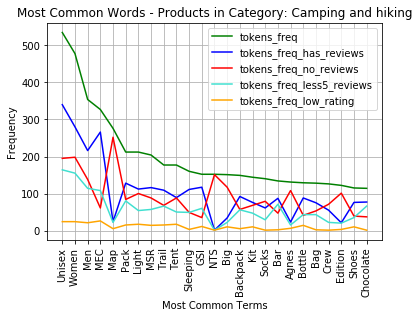

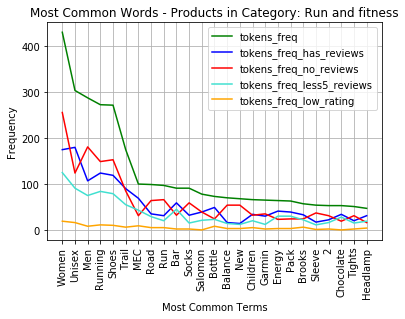

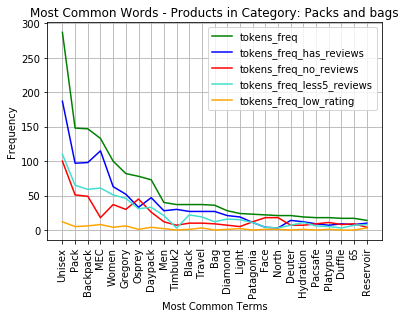

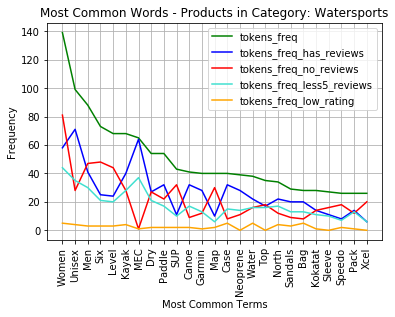

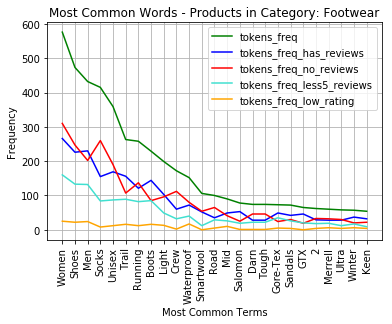

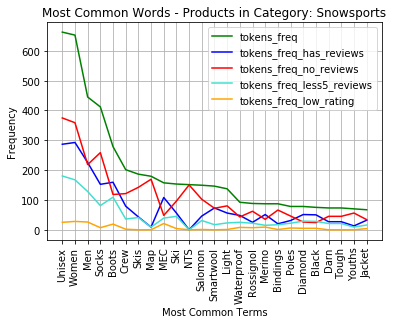

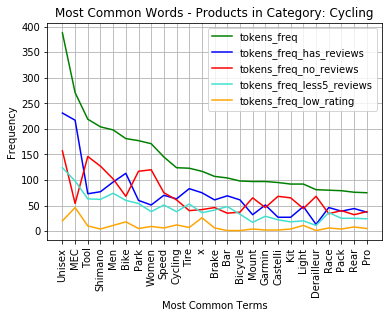

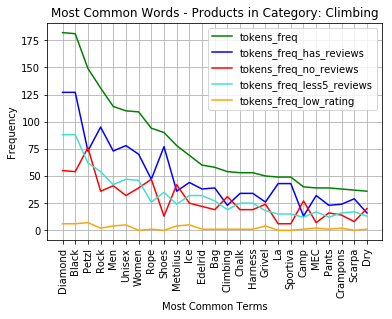

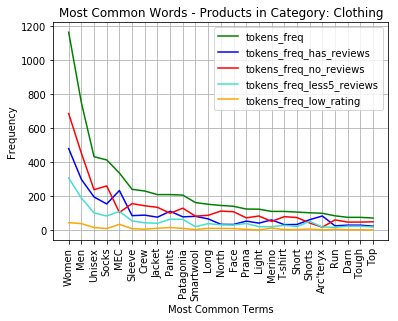

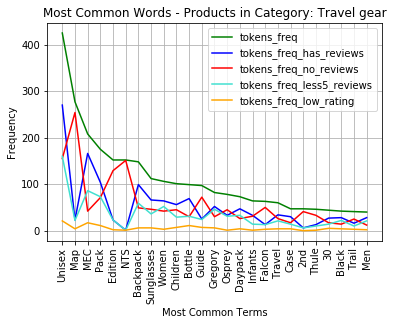

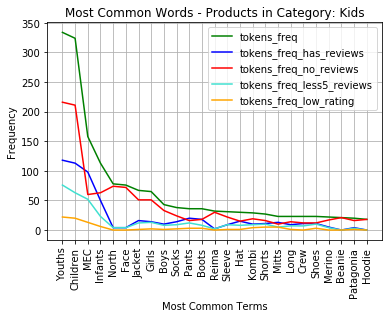

In [6]:
# view most common words within categories
for c in df_summary.category:
    temp = df_summary[df_summary['category'] == c]
    freq_dist = {}
    freq_dist['tokens_freq'] = temp['tokens_freq'].tolist()[0]
    freq_dist['tokens_freq_has_reviews'] = temp['tokens_freq_has_reviews'].tolist()[0]
    freq_dist['tokens_freq_no_reviews'] = temp['tokens_freq_no_reviews'].tolist()[0]
    freq_dist['tokens_freq_less5_reviews'] = temp['tokens_freq_less5_reviews'].tolist()[0]
    freq_dist['tokens_freq_low_rating'] = temp['tokens_freq_low_rating'].tolist()[0]
    most_common = [item for item, _ in freq_dist['tokens_freq'].most_common(25)] 
    colors = ["green", "blue", "red", "turquoise", "orange"]

    # loop over the dictionary keys to plot each distribution
    for i, label in enumerate(freq_dist):
        frequency = [freq_dist[label][term] for term in most_common]
        color = colors[i]
        plt.plot(frequency, color=color, label=label)
    plt.gca().grid(True)
    plt.xticks(np.arange(0, len(most_common), 1), most_common, rotation=90)
    plt.title("Most Common Words - Products in Category: {}".format(c))
    plt.xlabel("Most Common Terms")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")
    plt.show()

## Exploration of All Products (no categories)

In [7]:
# read in scraped csv file
products_df_unclean = pd.read_csv("mecscrape/mecscrape/mecproducts.csv")
#print(len(products_df_unclean))

# clean data (no category df)

# split string into rating, number of reviews, and product name
values = [" out of 5 stars with", "reviews yet. Be the "]   
products_df_unclean["product"] = products_df_unclean["product"].str.split(r"\b(?:{})\b".format("|".join(values)))

# add rating, number of reviews, and product name columns to dataframe
products_df = pd.DataFrame(products_df_unclean['product'].values.tolist(), 
                           columns=['rating', 'num_reviews'])

# add product titles column to clean df
products_df['title'] = products_df_unclean['title']

# remove all parts of the string that are not a rating or the number of reviews
products_df['rating'] = products_df["rating"].apply(lambda x: re.sub('[^0-9.,]+', '', x))
products_df['num_reviews'] = products_df['num_reviews'].apply(lambda x: re.sub('[a-zA-Z].*$', '', x))

# change column type to numeric for rating and num_reviews
products_df['rating'] = pd.to_numeric(products_df['rating'])
products_df['num_reviews'] = pd.to_numeric(products_df['num_reviews'])

products_df.drop_duplicates(keep = 'first', inplace = True)

# sort dataframe by most reviews to least reviews
products_df = products_df.sort_values(by=['num_reviews'], ascending = False)
#print(len(products_df))

# print head and tail of resulting df
#print(products_df.head())
#print(products_df.tail())

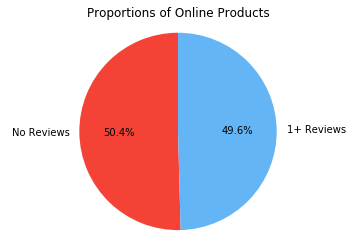

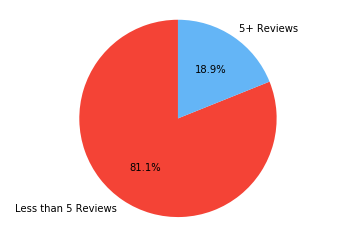

In [8]:
# Pie chart of reviews vs. no reviews
labels = 'No Reviews', '1+ Reviews'
sizes = [sum(products_df.num_reviews.isna()), sum(products_df.num_reviews.isna() == False)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors = ['#F44336','#64B5F6'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportions of Online Products')
plt.show()

# Pie chart of 5+ reviews vs. <5 reviews
labels2 = 'Less than 5 Reviews', '5+ Reviews'
sizes2 = [sum(products_df.num_reviews < 5) + sum(products_df.num_reviews.isna()), sum(products_df.num_reviews >= 5)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes2, labels=labels2, autopct='%1.1f%%', startangle=90, colors = ['#F44336','#64B5F6'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [9]:
# tokenize titles and add token titles to dataframe
sw = stopwords.words('english')
sw.extend(word_tokenize(punctuation))
sw.extend(["-", "\'s", "."])


clean_tokens = []
token_title = []
for row in products_df['title']:
    temp_tokens = []
    tokens = word_tokenize(row)
    for token in tokens:
        if token.lower() not in sw:
            clean_tokens.append(token)
            temp_tokens.append(token)
    token_title.append(temp_tokens)
    
products_df['token_title'] = token_title


In [10]:
# frequency distributions and alternative dataframes

# all titles
freq = nltk.FreqDist(clean_tokens)

# no review df and frequency distribution for no review tokens
no_review_df = products_df[products_df.num_reviews.isna()]
no_review_tokens = [item for sublist in no_review_df['token_title'] for item in sublist]
freq_no_review = nltk.FreqDist(no_review_tokens)

# frequency distribution for has review tokens
reviews_tokens = [item for sublist in products_df.token_title[products_df.num_reviews >= 1] for item in sublist]
freq_reviews = nltk.FreqDist(reviews_tokens)

# frequency distribution for less than 5 reviews tokens
less5_reviews_tokens = [item for sublist in products_df.token_title[products_df.num_reviews < 5] for item in sublist]
less5_freq_reviews = nltk.FreqDist(less5_reviews_tokens)

# low rating df and frequency distribution for poorly reviewed products tokens
low_score_df = products_df[products_df['rating'] < 3]
low_score_tokens = [item for sublist in low_score_df['token_title'] for item in sublist]
freq_low_score = nltk.FreqDist(low_score_tokens)

In [11]:
# MEC products - datafframe and frequency distributions

# MEC products dataframe
mec_products_df = products_df[products_df['title'].str.contains('MEC')]
mec_freq = nltk.FreqDist([item for sublist in mec_products_df['token_title'] for item in sublist])

# frequency distribution for 'has review' tokens
mec_reviews_tokens = [item for sublist in mec_products_df.token_title[mec_products_df.num_reviews >= 1] for item in sublist]
mec_freq_reviews = nltk.FreqDist(mec_reviews_tokens)

# frequency distribution for no reviews tokens
mec_no_reviews_tokens = [item for sublist in mec_products_df.token_title[mec_products_df.num_reviews.isna()] for item in sublist]
mec_freq_no_reviews = nltk.FreqDist(mec_no_reviews_tokens)

# frequency distribution for low rating
mec_low_rating_tokens = [item for sublist in mec_products_df.token_title[mec_products_df.rating < 3] for item in sublist]
mec_low_rating_freq = nltk.FreqDist(mec_low_rating_tokens)

# frequency distribution for less than 5 reviews tokens
mec_less5_reviews_tokens = [item for sublist in mec_products_df.token_title[mec_products_df.num_reviews < 5] for item in sublist]
mec_less5_freq_reviews = nltk.FreqDist(mec_less5_reviews_tokens)

In [12]:
# Add all products to summary statistics dataframe
df_summary = df_summary.append({'category': 'All', 
                   'num_products': len(products_df), 
                   'prop_has_reviews': 1-round(sum(products_df.num_reviews.isna())/ len(products_df), 3),
                  'prop_less5_reviews': round(sum(products_df.num_reviews < 5)/(len(products_df)-sum(products_df.num_reviews.isna())),3),
                  'prop_low_rating': round(sum(products_df.rating < 3)/(len(products_df)-sum(products_df.num_reviews.isna())),3),
                  'mean_rating': round(products_df.rating.mean(),2),
                  'median_rating': round(products_df.rating.median(),2),
                  'mean_num_reviews': round(products_df.num_reviews.mean(),2),
                  'median_num_reviews': round(products_df.num_reviews.median(),2),
                  'tokens_freq': freq,
                  'tokens_freq_has_reviews': freq_reviews,
                  'tokens_freq_no_reviews': freq_no_review,
                  'tokens_freq_less5_reviews': less5_freq_reviews,
                  'tokens_freq_low_rating': freq_low_score}, ignore_index = True)

# add MEC products to summary statistics dataframe
df_summary = df_summary.append({'category': 'MEC', 
                   'num_products': len(mec_products_df), 
                   'prop_has_reviews': 1-round(sum(mec_products_df.num_reviews.isna())/ len(mec_products_df), 3),
                  'prop_less5_reviews': round(sum(mec_products_df.num_reviews < 5)/(len(mec_products_df)-sum(mec_products_df.num_reviews.isna())),3),
                  'prop_low_rating': round(sum(mec_products_df.rating < 3)/(len(mec_products_df)-sum(mec_products_df.num_reviews.isna())),3),
                  'mean_rating': round(mec_products_df.rating.mean(),2),
                  'median_rating': round(mec_products_df.rating.median(),2),
                  'mean_num_reviews': round(mec_products_df.num_reviews.mean(),2),
                  'median_num_reviews': round(mec_products_df.num_reviews.median(),2),
                  'tokens_freq': mec_freq,
                  'tokens_freq_has_reviews': mec_freq_reviews,
                  'tokens_freq_no_reviews': mec_freq_no_reviews,
                  'tokens_freq_less5_reviews': mec_less5_freq_reviews,
                  'tokens_freq_low_rating': mec_low_rating_freq}, ignore_index = True)

### Summary Statistics Dataframe

See dictionary below for the meanings of column headings.

In [13]:
df_summary

,category,num_products,prop_has_reviews,prop_less5_reviews,prop_low_rating,mean_rating,median_rating,mean_num_reviews,median_num_reviews,tokens_freq,tokens_freq_has_reviews,tokens_freq_no_reviews,tokens_freq_less5_reviews,tokens_freq_low_rating
0,Camping and hiking,5457,0.548,0.565,0.111,4.10,4.3,33.22,4.0,"{'Aeropress': 2, 'Coffee': 29, 'Espresso': 12,...","{'Aeropress': 1, 'Coffee': 16, 'Espresso': 8, ...","{'AlpineAire': 12, '7': 7, 'Day': 10, 'Meal': ...","{'Ursack': 1, 'Major': 2, 'XL': 3, 'Bear': 5, ...","{'Hydrapak': 9, 'Shape': 1, 'Shift': 1, 'Reser..."
1,Run and fitness,1882,0.489,0.656,0.105,4.13,4.4,14.14,3.0,"{'MEC': 100, 'First': 5, 'Aid': 3, 'Bag': 9, '...","{'MEC': 69, 'First': 1, 'Aid': 2, 'Bag': 8, 'S...","{'Dr.': 1, 'Scholl': 1, 'Extra': 2, 'Soft': 3,...","{'Advanced': 6, 'Medical': 6, 'Kits': 6, 'Blis...","{'Advanced': 2, 'Medical': 2, 'Kits': 2, 'Mole..."
2,Packs and bags,630,0.610,0.648,0.076,4.26,4.5,10.20,3.0,"{'MEC': 133, 'Formula': 1, 'Book': 1, 'Bag': 3...","{'MEC': 115, 'Formula': 1, 'Book': 1, 'Bag': 2...","{'Patagonia': 12, 'Tres': 2, 'Pack': 51, '25L'...","{'MEC': 61, 'Formula': 1, 'Book': 1, 'Bag': 12...","{'MEC': 8, 'Eyas': 1, 'Daypack': 4, 'Children'..."
3,Watersports,909,0.545,0.661,0.109,4.04,4.2,9.14,3.0,"{'Fathom': 19, 'Los': 1, 'Cabos': 1, 'Mask': 1...","{'Fathom': 7, 'Aruba': 1, 'Junior': 1, 'Mask':...","{'Fathom': 12, 'Los': 1, 'Cabos': 1, 'Mask': 9...","{'Fathom': 6, 'Aruba': 1, 'Junior': 1, 'Mask':...","{'Fathom': 2, 'Anguilla': 1, 'Equalizing': 1, ..."
4,Footwear,1396,0.488,0.573,0.097,4.17,4.4,40.42,3.0,"{'MEC': 34, 'Hut': 2, 'Booties': 4, 'Unisex': ...","{'MEC': 25, 'Hut': 2, 'Booties': 4, 'Unisex': ...","{'Toesox': 1, 'Elle': 1, 'Half': 2, 'Toe': 8, ...","{'MEC': 14, 'Hut': 1, 'Slipper': 1, 'Unisex': ...","{'Moneysworth': 1, 'Hiker': 2, 'Laces': 1, 'Ro..."
5,Snowsports,2505,0.412,0.629,0.117,4.10,4.4,9.86,3.0,"{'Burton': 7, 'Dump': 1, 'Truck': 1, 'Splitboa...","{'Smith': 22, 'Compass': 3, 'Snow': 24, 'Helme...","{'Burton': 6, 'Dump': 1, 'Truck': 1, 'Splitboa...","{'Smith': 10, 'Compass': 2, 'Snow': 13, 'Helme...","{'MEC': 22, 'Synergy': 3, 'Gore-Tex': 3, 'Jack..."
6,Cycling,2994,0.511,0.626,0.127,3.99,4.2,10.50,3.0,"{'North': 1, 'Shore': 1, 'Trail': 30, 'Map': 5...","{'North': 1, 'Shore': 1, 'Trail': 8, 'Map': 3,...","{'Gem': 2, 'Trek': 2, 'Publishing': 2, 'Bragg'...","{'North': 1, 'Shore': 1, 'Trail': 8, 'Map': 3,...","{'Ghost': 1, 'Kato': 1, '20': 3, '2.0': 3, 'Yo..."
7,Climbing,1271,0.548,0.704,0.056,4.30,4.5,5.14,3.0,"{'Slackers': 2, 'Ninjaline': 1, '36': 2, 'Intr...","{'Slackline': 7, 'Industries': 7, 'Play': 2, '...","{'Slackers': 2, 'Ninjaline': 1, '36': 1, 'Intr...","{'Slackline': 7, 'Industries': 6, 'Play': 2, '...","{'Slackline': 1, 'Industries': 1, '36': 1, 'Fr..."
8,Clothing,2358,0.414,0.612,0.097,4.19,4.5,10.33,3.0,"{'Prana': 123, 'Jola': 1, 'Dress': 34, 'Women'...","{'Prana': 52, 'Jola': 1, 'Dress': 15, 'Women':...","{'Toad': 14, 'Co': 14, 'Daisy': 3, 'Rib': 2, '...","{'Toad': 16, 'Co': 16, 'Cambria': 1, 'Sweater'...","{'Synergy': 4, 'Shimmer': 1, 'Dress': 1, 'Wome..."
9,Travel gear,2342,0.432,0.634,0.133,4.07,4.4,57.36,3.0,"{'Sun': 24, 'Bum': 16, 'Premium': 3, 'SPF': 29...","{'Sun': 8, 'Bum': 7, 'Premium': 1, 'SPF': 16, ...","{'Kavu': 9, 'Mondo': 1, 'Spender': 1, 'Wallet'...","{'Sun': 6, 'Bum': 5, 'Premium': 1, 'SPF': 12, ...","{'Sun': 3, 'Bum': 3, 'SPF': 3, '30': 5, 'Lip':..."


### Summary Dataframe Dictionary

| Dataframe Column Name | Meaning |
|-----------------------|---------|
| category | Product category from MEC.ca |
| num_products | The number of products that fall within that specific category. |
| prop_has_reviews | The proportion of products in that category that has 1+ reviews (ex. 0.546 is 54.6% of products). |
| prop_less5_reviews | Including ONLY the products that have 1+ reviews, the proportion of those products that have less than 5 reviews (i.e. products with between 1-4 reviews).  |
| prop_low_rating | Including ONLY the products that have 1+ reviews, the proportion of those products that have a rating of less than 3 stars. |
| mean_rating | The average rating of products within that category. |
| median_rating | The median rating of products within that category. |
| mean_num_reviews | The average number of reviews that a product within that category has. | 
| median_num_reviews | The median number of reviews that a product within that category has. |
| tokens_freq | All the words/numbers that occur in product titles and the frequency that a word occurs in a product title within that category. |
| tokens_freq_has_reviews |  All the words/numbers that occur in product titles and the frequency that a word occurs in a product title for products that have 1+ reviews within that category. |
| tokens_freq_no_reviews | All the words/numbers that occur in product titles and the frequency that a word occurs in a product title for products that have NO reviews within that category. |
| tokens_freq_less5_reviews | All the words/numbers that occur in product titles and the frequency that a word occurs in a product title for products that have have 1-4 reviews within that category. |
| tokens_freq_low_rating | All the words/numbers that occur in product titles and the frequency that a word occurs in a product title for products that have a less than 3 star rating and 1+ reviews within that category. |

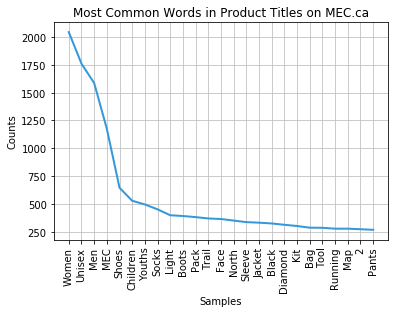

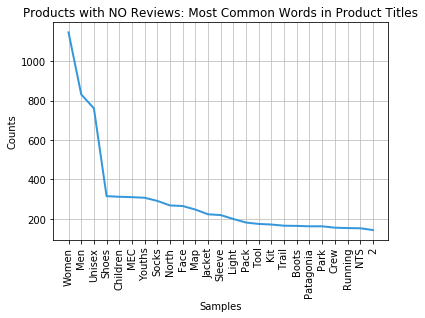

In [14]:
# plot of most common words in titles of all products on MEC.ca
freq.plot(25, cumulative=False, color = '#3498DB', title = 'Most Common Words in Product Titles on MEC.ca')

freq_no_review.plot(25, cumulative=False, color = '#3498DB', title = 'Products with NO Reviews: Most Common Words in Product Titles')

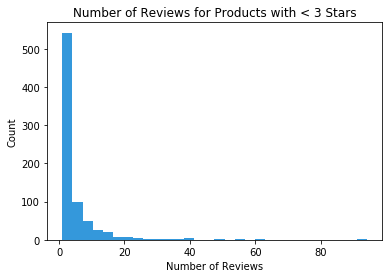

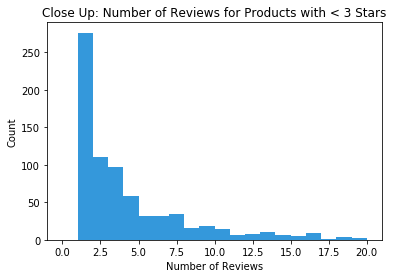

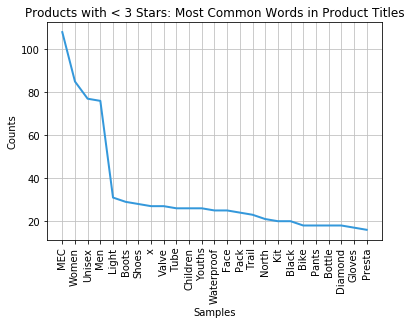

Total number of rated products with a less than 3 star rating: 774


In [15]:
#num_bins = len(set(low_score_df['num_reviews']))
plt.hist(low_score_df['num_reviews'], bins = 30, color = '#3498DB')
plt.ylabel("Count")
plt.xlabel("Number of Reviews")
plt.title("Number of Reviews for Products with < 3 Stars")
#plt.set_color_palette(['red'])
plt.show()

plt.hist(low_score_df[low_score_df['num_reviews'] < 20]['num_reviews'], 
         bins = 20, range = [0, 20],
         color = '#3498DB')
plt.ylabel("Count")
plt.xlabel("Number of Reviews")
plt.title("Close Up: Number of Reviews for Products with < 3 Stars")
plt.show()

freq_low_score.plot(25, cumulative=False, color = '#3498DB', 
                    title = 'Products with < 3 Stars: Most Common Words in Product Titles')

print("Total number of rated products with a less than 3 star rating:", len(low_score_df))

### Products with < 3 star rating:

In [16]:
print("mean number of reviews:", round(low_score_df.num_reviews.mean(), 2))
print("25th quantile number of reviews:", 
      round(low_score_df.num_reviews.quantile(0.25), 2))
print("median number of reviews:", round(low_score_df.num_reviews.median(), 2))
print("60th quantile number of reviews:", 
      round(low_score_df.num_reviews.quantile(0.60), 2))
print("75th quantile number of reviews:", 
      round(low_score_df.num_reviews.quantile(0.75), 2))

mean number of reviews: 5.03
25th quantile number of reviews: 1.0
median number of reviews: 2.5
60th quantile number of reviews: 3.0
75th quantile number of reviews: 6.0


#### Products with < 3 stars and 20+ reviews:

In [17]:
print(len(low_score_df[low_score_df.num_reviews >= 20]))
low_score_df[low_score_df.num_reviews >= 20]

31


,rating,num_reviews,title,token_title
13939,2.7,94.0,Light My Fire Spork,"[Light, Fire, Spork]"
2225,2.2,62.0,Spot Gen3 Satellite GPS Messenger Beacon,"[Spot, Gen3, Satellite, GPS, Messenger, Beacon]"
498,1.9,56.0,MEC 700 x 23-25C Tube (60mm Presta Valve),"[MEC, 700, x, 23-25C, Tube, 60mm, Presta, Valve]"
13957,2.6,56.0,CycleAware Roadie Road Bike Mirror,"[CycleAware, Roadie, Road, Bike, Mirror]"
13955,2.9,50.0,Yaktrax Running Ice Traction Device - Unisex,"[Yaktrax, Running, Ice, Traction, Device, Unisex]"
348,1.9,50.0,MEC 700 x 23-25C Tube (48mm Presta Valve),"[MEC, 700, x, 23-25C, Tube, 48mm, Presta, Valve]"
9370,2.7,41.0,MEC Tire Lever Set,"[MEC, Tire, Lever, Set]"
13959,2.0,41.0,Planet Bike Air Kiss CO2 Inflator,"[Planet, Bike, Air, Kiss, CO2, Inflator]"
276,2.0,39.0,MEC Orion USB Rear Light,"[MEC, Orion, USB, Rear, Light]"
3459,2.6,39.0,Planet Bike Quick Stop 10mm x 1.8m Keyed Cable...,"[Planet, Bike, Quick, Stop, 10mm, x, 1.8m, Key..."
